In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from torch import nn
from torch.nn import functional as F
from dreamz.cppn import composite_activation


class Net(nn.Module):
    def __init__(self, base_model, reps=2, output_channels=3):
        super(Net, self).__init__()
        self.base_model = base_model
        
        s = self.base_model.output_channels
        
        self.conv1 = self.get_group_of_layers(reps, s, s)
        self.conv2 = self.get_group_of_layers(reps - 1, s * 2, s)
        self.conv3 = nn.Conv2d(s * 2, output_channels, 3)
        self.final_act = nn.Sigmoid()
        
    def get_group_of_layers(self, reps, s0, s, k=1):
        this = []
        for i in range(reps):
            this += [nn.Conv2d(s0, s, k)]
            nn.init.normal_(
                this[-1].weight,
                std=np.sqrt(1 / (s0 * (k ** 2)))
            )
#             this += [nn.ReLU6()]
            this += [Lambda(composite_activation)]
            s0 = s * 2
        return nn.Sequential(*this)
        

    def forward(self, x):
        x = self.base_model.layers(x)
        x = self.conv1(x)
        x = F.upsample_bilinear(x, scale_factor=2)
        x = self.conv2(x)
        x = F.upsample_bilinear(x, scale_factor=2)
        x = self.conv3(x)
        x = self.final_act(x)
        return x[:, :, 3:-3, 3:-3]

In [63]:
import time
from skimage.io import imsave
from dreamz.utils import get_latest_filename, tch_im_to_np
from dreamz.cppn import get_xy_mesh, CPPNNet
from dreamz.render import train_visualiser
from dreamz.torch_utils import Lambda, adjust_learning_rate
from dreamz.cppn import composite_activation
import torch
from torch import nn
from torchvision import models
from torch.nn import functional as F
from torch import optim
import numpy as np


def train(size, widths, imagenet_model, chan_to_opt, log_interval):
    base = CPPNNet(widths, input_channels=5, output_channels=widths[-1])
    viz = Net(base, reps=1).to(device)
    viz = viz.to(device)
    viz = nn.DataParallel(viz)
    mean = torch.FloatTensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
    std = torch.FloatTensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)
    
    def get_alphas(batch_size, device):
#         alphas = torch.linspace(-1, 0.9, batch_size) + torch.rand(size=[batch_size]) * 0.1
#         alphas = torch.randn(size=[batch_size])
        alphas = torch.tensor(np.random.dirichlet(np.array([0.08]*3), [batch_size]).astype(np.float32))
        alphas = alphas.to(device)
        return alphas

    def mse_loss_fn(ims, alphas, distance_constant=0.2):
        ims = ims.view(ims.shape[0], -1)
        actual_distances = torch.abs(ims.unsqueeze(0) - ims.unsqueeze(0).permute(1, 0, 2)).mean(2)
        return -torch.mean(actual_distances)
#         targ_distances = distance_constant * torch.abs(alphas.unsqueeze(0) - alphas.unsqueeze(1))
#         return torch.mean(actual_distances - targ_distances)
    
    def imgnet_objective(output, alphas):
        r = imagenet_model((output - mean) / std)
    #     return torch.mean((r - targ) ** 2)
#         loss = -r[:, chan_to_opt].mean()
        loss = r.mean() * 1
        loss = -(r[:, chan_to_opt:(chan_to_opt+3)] * alphas).mean() * 2
#         mse_loss = mse_loss_fn(output, alphas)
        loss = loss# + mse_loss * 0
        return loss
    
    batch_size = 32
    class XYGetter:
        def __init__(self, size):
            self.size = size
            xy = get_xy_mesh(size).to(device)
            
            self.xy = get_xy_mesh(size).to(device)
            self.xy2 = get_xy_mesh([int(i * 1.5) for i in size]).to(device)
            self.xy4 = get_xy_mesh([int(i * 2.0) for i in size]).to(device)
            print(self.xy.shape, self.xy2.shape, self.xy4.shape)

        def get_xy(self, num=64):
            xy_crop = []
            h, w = size
            for i in range(num):
                r = np.random.rand()
                if i == 0:
                    x0, x1 = 30, 30 + h
                    xy_crop.append(self.xy[:, :, :, x0:x1])
                elif r < 0.2:
                    x0 = np.random.choice([0, w - h])
                    x1 = x0 + h
                    xy_crop.append(self.xy[:, :, :, x0:x1])
                elif r < 0.6:
                    x0 = np.random.randint(0, self.xy2.shape[3] - h)
                    x1 = x0 + h
                    y0 = np.random.randint(0, self.xy2.shape[2] - h)
                    y1 = y0 + h
                    xy_crop.append(self.xy2[:, :, y0:y1, x0:x1])
                else:
                    x0 = np.random.randint(0, self.xy4.shape[3] - h)
                    x1 = x0 + h
                    y0 = np.random.randint(0, self.xy4.shape[2] - h)
                    y1 = y0 + h
                    xy_crop.append(self.xy4[:, :, y0:y1, x0:x1])
            xy_crop = torch.cat(xy_crop, 0)
            return xy_crop
    xy_getter = XYGetter(size)
    def im_gen_fn(pct_done=0.0):
        xy = xy_getter.get_xy(batch_size)
        alphas = get_alphas(batch_size, device)
        inp = torch.cat([xy, alphas.view(-1, 3, 1, 1).repeat([1, 1, *xy.shape[-2:]])], 1)
        return viz(inp), alphas

    opt = optim.Adam(viz.parameters(), lr=0.003)
    adj = lambda opt: adjust_learning_rate(opt, 0.1)
    train_visualiser(imgnet_objective, im_gen_fn, opt, iters=1000,
                     log_interval=log_interval, sched=[(800, adj)])
    return viz

def get_imagenet_model():
    model = models.resnet18(pretrained=True).to(device)
    model = nn.Sequential(*(
        [i for i in model.children()][:-4] + [
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            Lambda(lambda x: x[:, :, 0, 0])]))
    return model.eval()

device = 'cuda'
imagenet_model = get_imagenet_model()

In [64]:
imagenet_model = imagenet_model.to(device)
imagenet_model = nn.DataParallel(imagenet_model)

In [65]:
# def printt():
#     print(imagenet_model(torch.ones(size=[1, 3, 224, 224])).shape)
# printt()

  0%|          | 0/1000 [00:00<?, ?it/s]

Training 25
torch.Size([1, 2, 59, 105]) torch.Size([1, 2, 88, 157]) torch.Size([1, 2, 118, 210])
cost -0.09476232528686523


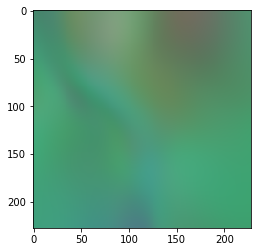

  5%|▌         | 50/1000 [00:04<01:27, 10.83it/s]

cost -0.3196353614330292


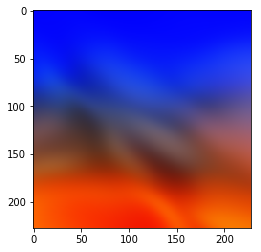

 10%|█         | 100/1000 [00:09<01:23, 10.77it/s]

cost -0.37755680084228516


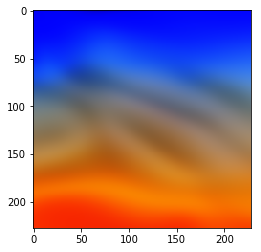

 15%|█▌        | 150/1000 [00:14<01:19, 10.76it/s]

cost -0.37952813506126404


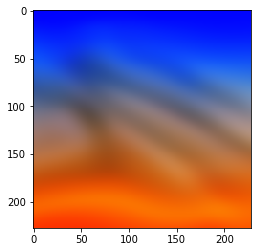

 20%|██        | 200/1000 [00:18<01:13, 10.88it/s]

cost -0.3771226108074188


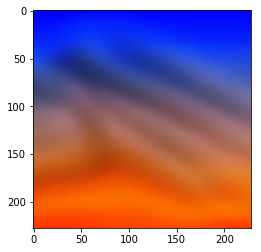

 25%|██▌       | 250/1000 [00:23<01:09, 10.76it/s]

cost -0.4128687381744385


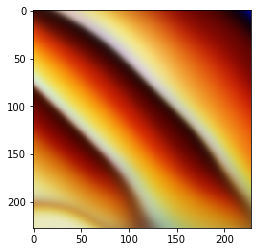

 30%|███       | 300/1000 [00:28<01:05, 10.77it/s]

cost -0.4408179223537445


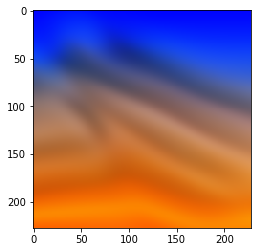

 35%|███▌      | 350/1000 [00:33<00:59, 10.84it/s]

cost -0.4087343215942383


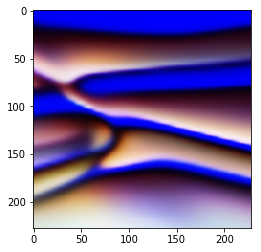

 40%|████      | 400/1000 [00:38<00:55, 10.79it/s]

cost -0.43588173389434814


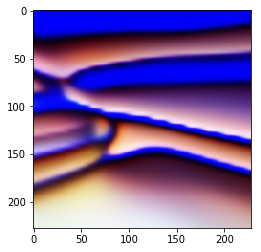

 45%|████▌     | 450/1000 [00:42<00:51, 10.74it/s]

cost -0.382362425327301


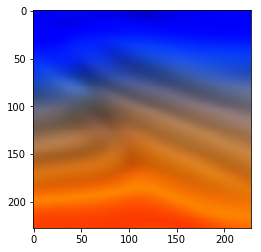

 50%|█████     | 500/1000 [00:47<00:46, 10.72it/s]

cost -0.42450809478759766


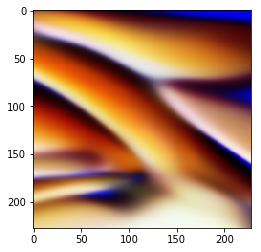

 55%|█████▌    | 550/1000 [00:52<00:41, 10.76it/s]

cost -0.4363701045513153


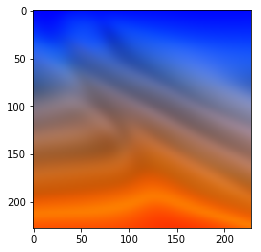

 60%|██████    | 600/1000 [00:57<00:37, 10.72it/s]

cost -0.4356937110424042


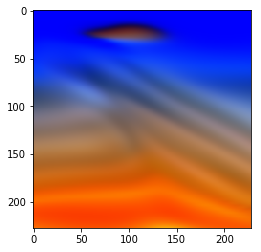

 65%|██████▌   | 650/1000 [01:01<00:32, 10.73it/s]

cost -0.42438340187072754


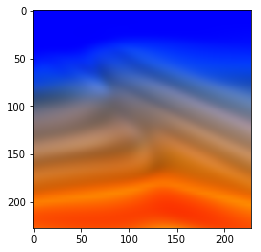

 70%|███████   | 700/1000 [01:06<00:28, 10.71it/s]

cost -0.44648277759552


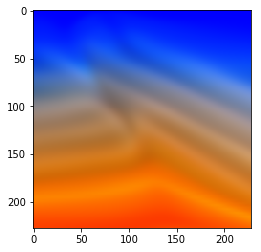

 75%|███████▌  | 750/1000 [01:11<00:23, 10.78it/s]

cost -0.4676823019981384


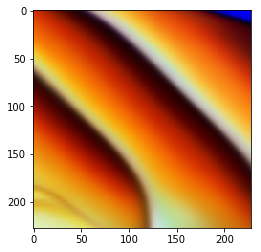

 80%|████████  | 800/1000 [01:16<00:18, 10.65it/s]

Changed learning rate to 0.00030000000000000003
cost -0.45830225944519043


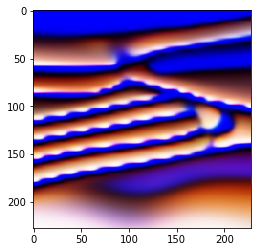

 85%|████████▌ | 850/1000 [01:21<00:14, 10.69it/s]

cost -0.4799659848213196


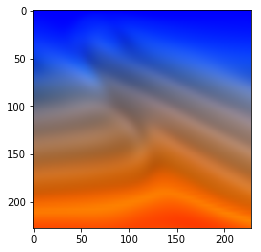

 90%|█████████ | 900/1000 [01:25<00:09, 10.75it/s]

cost -0.4781021475791931


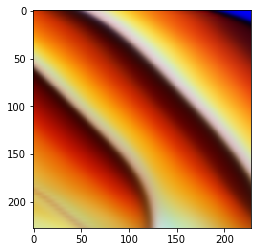

 95%|█████████▌| 950/1000 [01:30<00:04, 10.70it/s]

cost -0.4695201814174652


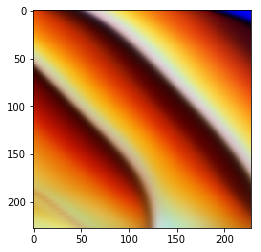

100%|██████████| 1000/1000 [01:35<00:00, 10.72it/s]

Took 95.49315333366394 seconds


In [66]:
size = [59, 105]
chan_to_opt = 25

log_interval = 50
widths = [24] * 8

now = time.time()
print('Training {}'.format(chan_to_opt))
viz = train(size, widths, imagenet_model, chan_to_opt, log_interval)
print('Took {} seconds'.format(time.time() - now))
now = time.time()

In [95]:
from dreamz.utils import tch_im_to_pil
ims_savedir = '../data/output_ims3/'
bigsize = [272, 482]
# bigsize = [i//2 for i in bigsize]
xy_big = get_xy_mesh(bigsize).to(device)
def big_save_fn(alpha):
#     xy_big = get_xy_mesh([1080, 1920]).to(device)
    alpha = torch.FloatTensor(alpha).to(device).view(1, 3, 1, 1).repeat([1, 1, *xy_big.shape[-2:]])
    res = viz(torch.cat([xy_big, alpha], 1))
#     imsave(get_latest_filename(ims_savedir), tch_im_to_np(res))
    return (tch_im_to_np(res))
dims = big_save_fn(np.array([0., 0., 1.])).shape[:2]
dims

(1080, 1920)

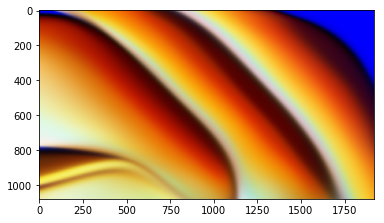

In [96]:
plt.imshow(big_save_fn(np.array([1., 0., 0.])))

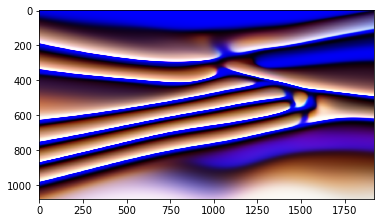

In [97]:
plt.imshow(big_save_fn(np.array([0., 1., 0.])))

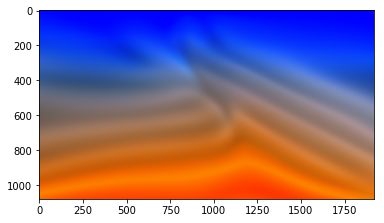

In [98]:
plt.imshow(big_save_fn(np.array([0., 0., 1.])))

In [94]:
import numpy as np
from PIL import Image, ImageDraw
import cv2
from tqdm import tqdm
import time

# fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
# video = cv2.VideoWriter('test2.mp4', fourcc, 30, tuple(reversed(dims)))

count = 0
now = time.time()
for i in range(3):
    alphas = np.array([0., 0., 0.])
    for alpha in (np.linspace(0., 1.0, 100)):
        alphas[i] = alpha
        im_np = big_save_fn(alphas)
#         video.write(cv2.cvtColor(im_np, cv2.COLOR_RGB2BGR))
        count += 1
    for alpha in (np.linspace(1.0, 0., 20)):
        alphas[i] = alpha
        im_np = big_save_fn(alphas)
#         video.write(cv2.cvtColor(im_np, cv2.COLOR_RGB2BGR))
        count += 1
# video.release()
count / (time.time() - now)

71.43678037748553